# Models 

## Functions

In [1]:
# Three parameters that determine the beta parameter for the SEIR
# R0
# distancing: is there social distancing: 0/1
# policyparameters: how does distancing affect R0. 
# Default: policyparameters$distancingeffect = 0.6
getbeta = function (t, distancing, R0, policyparameters) { 
    R = R0
    if (distancing){
        R = R * (1 - policyparameters$distancingeffect)
    }
    # Use R0 = beta/gamma for SIR. Use gamma  = 1/gamma based on average of 5 days spent in I
    return (R/gamma)
}


#S : 1
#E : 2
#I : 3
#HH: 4
#HC: 5
#C : 6
#R : 7
# KEY FUNCTION
# Make changes here to change policy or transition rates
maketransmatrix = function (t, currentstate, distancing, R0, policyparameters, gamma,nu){
    beta = getbeta (t, distancing, R0, policyparameters)
    transmatrix = matrix (c (1,2, beta, 
                             2,3, 1/(nu),
                             3,4, 0.0308/(gamma),
                             3,5, 0.0132/(gamma),
                             3,7, 0.956/(gamma),
                             4,7, 1/6,
                             5,6, 1/8,
                             6,7, 1/10), ncol = 3, byrow = T)
    return (transmatrix)
}

# KEY FUNCTION
# Use this to set SD
# One policy:  distancing is on if I(t) goes above i1 and off if I(t) goes below i2. Do nothing otherwise
distancingpolicy = function ( t, currentstate, distancing, policyparameters) { 
    if (currentstate[3]  >= policyparameters$hi){
        return (1)
    } 
    if (currentstate[3] <= policyparameters$lo){
        return (0)
    }
    return (distancing)
}

# Main function
# Note: In this SEIR model, we model the fraction of individuals in each compartment.
# 
# Inputs: 
#   startstate : vector of length number of states. Each entry is >=0 and <=1. All entries sum to 1. Default c(1,0,0,0,0,0,0)
#   startt : starttime (in days) 
#   stopt: stoptime  (in days)
#   deltat: unit of time to simulate for one step. Default: 1/10 for 1/10 of a day. 
#   R0: reproduction number
#   policyparameters: list of all the things that are relevant for the policy. e.g. how much does distancing reduce R0
#   debug: for verbose mode
# 
# Outputs: A list. 
#   states: matrix of time X # number of states. Use this to plot e.g. infected vs time

evolve = function (startstate, startt, stopt, deltat = 1/10, R0 = 2, policyparameters =list(distancingeffect = 0.6, hi = 37.5/1e4, low = 10/1e4) , debug = FALSE,gamma=5,nu=4.6 ){ 
    t = startt
    t1 = 1
    nstates = length (startstate)
    nt = stopt - startt
    states = rep(0, nstates*ceiling(nt/deltat))
    states = matrix (states, ceiling(nt/deltat), nstates)
    times = rep(0, ceiling(nt/deltat))
    distancings = rep(0, ceiling(nt/deltat))

    currentstate = startstate
    cumstate = currentstate
    cases = rep(0,nrow(states))
    allcases = 0 

    states[t1,] = currentstate
    times[t1] = t
    cases[t1] = 0
    distancing = 0
    trans = maketransmatrix (t, currentstate, distancing, R0, policyparameters,gamma,nu ) 
    vals = rep(0, nrow(trans))


    while (t<stopt){  
        delta = rep(0, nstates)


        if (debug) { 
            cat ("*******\n")
            cat ("time = " ,t,"\n")
            cat ("current state = ", currentstate,"\n")
        }

        distancing = distancingpolicy (t, currentstate, distancing, policyparameters)
        distancings[t]=distancing
        # Time-dependent transition matrix
        # Can change depending on policy
        # Can also modify to have seasonal effects like in Kissler et al.
        trans = maketransmatrix (t, currentstate, distancing, R0, policyparameters,gamma,nu) 


        for (i in 1:nrow(trans)) {
            tmp = trans[i,]

            # For each transition, get the rate. 
            val = tmp[3]

            # Handling the non-linear transition: S->E  = \beta SI
            if ( tmp[1]==1 && tmp[2]==2){ 
                val = val * currentstate[3]

                # In the initial few time steps, this allows for some individuals to go from S->E (since the default start state is c(1,0,0,0,0,0,0))    
                if (t < startt + 3.5){
                    val = val + 0.01/7
                }
                val = val * currentstate[1]
            } else {
               val = val * currentstate[tmp[1]]
            }
            vals[i] = val        
            delta[tmp[1]] = delta[tmp[1]] - val     
            delta[tmp[2]] = delta[tmp[2]] + val     

            if (tmp[2]==4 || tmp[2]==5){
                allcases = allcases + val
            }

        }        

        if (t1 > nrow(states)){
            states = rbind (states,currentstate)
            times = c(times,t)
            cases = c(cases, allcases)
        } else {
            states[t1,] = currentstate
            times[t1] = t
            cases[t1] = allcases
        }        
        delta = delta * deltat;
        t = t + deltat
        t1 = t1 + 1
        if (debug) {
            cat ("trans = ", vals,"\n")
        }

        currentstate = currentstate + delta
        cumstate = cumstate + currentstate
    }
    rownames (states) = times
    return (list(states=states, startt = startt, stopt = stopt, startstate = startstate, trans = trans, times = times, cases = cases,distancings=distancings)) 
}

# Create simulations for $\tau$ and $R_0$

In [280]:
startstate = c(1,0,0,0,0,0,0)
startt = 70

for (r0 in seq(1, 8, length=100)){
    for (gamma in seq(2,55,length=54)){

        nu = 4.6
        out = evolve (startstate=startstate, startt = startt, stopt = 365 + startt, policyparameters = list(distancingeffect = 0.0, hi = 37.5/1e4, low = 10/1e4), deltat=1,R0=r0,gamma=gamma_fix,nu=nu)
        x = out$cases
        
        out2 = evolve (startstate=startstate, startt = startt, stopt = 4*365 + startt, policyparameters = list(distancingeffect = 0.6, hi = 37.5/1e4, low = 10/1e4), deltat=1,R0=r0,gamma=gamma_fix,nu=nu)
        dist = out2$distancings
        
        endDist = tail(which(dist==1),n=1)-startt
        if(length(endDist)==0){
            endDist = 1   
        }
        name  <- sprintf("r_gamma_sims9/cases_r0_%.4f_endDist_%.1f_gamma_%.4f.csv",r0,endDist,gamma)
        write.csv(x,name)
        
       
    }
}
    

# Run single simulation

In [20]:
startstate = c(1,0,0,0,0,0,0)
startt = 70
gamma=19
nu = 4.6
r0=1.8
distancingeffect = 0.6
out = evolve (startstate=startstate, startt = startt, stopt = 3000 + startt, policyparameters = list(distancingeffect = distancingeffect, hi = 37.5/1e4, low = 10/1e4), deltat=1,R0=r0,gamma=gamma)
x = out$cases
sick = out$state[,3]
dist = out$distancings

endDist = tail(which(dist==1),n=1)-startt
if(length(endDist)==0){
    endDist = 1      
}

name  <- sprintf("sick_r0_%.4f_endDist_%.1f_nu_%.1f_gamma_%.4f.csv",r0,endDist,nu,gamma)
write.csv(sick,name)
name  <- sprintf("dist_r0_%.4f_endDist_%.1f_nu_%.1f_gamma_%.4f.csv",r0,endDist,nu,gamma)
write.csv(dist,name)



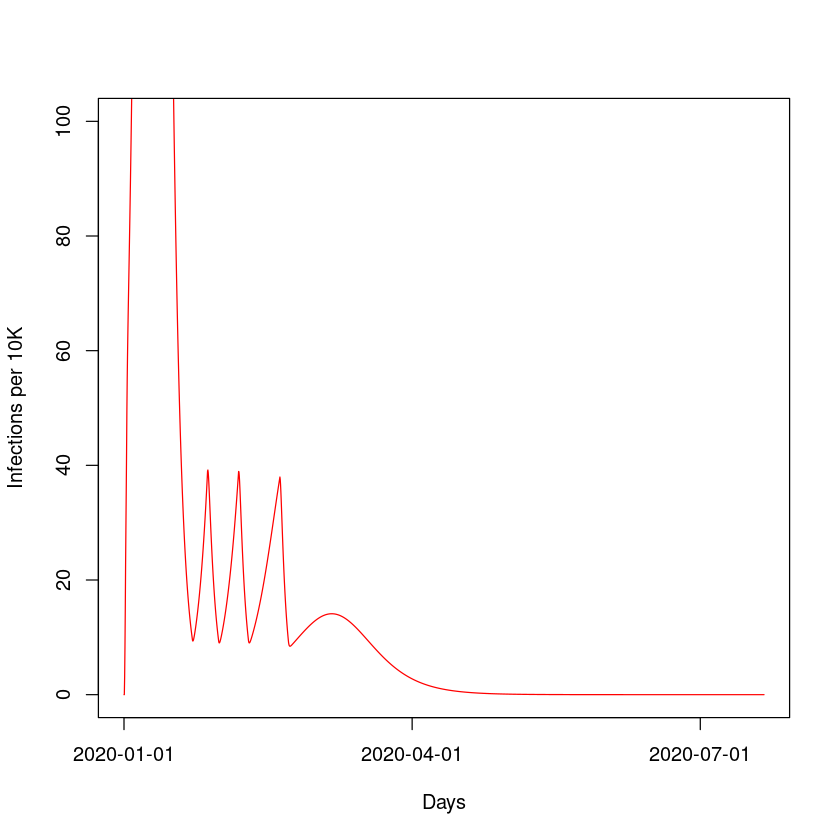

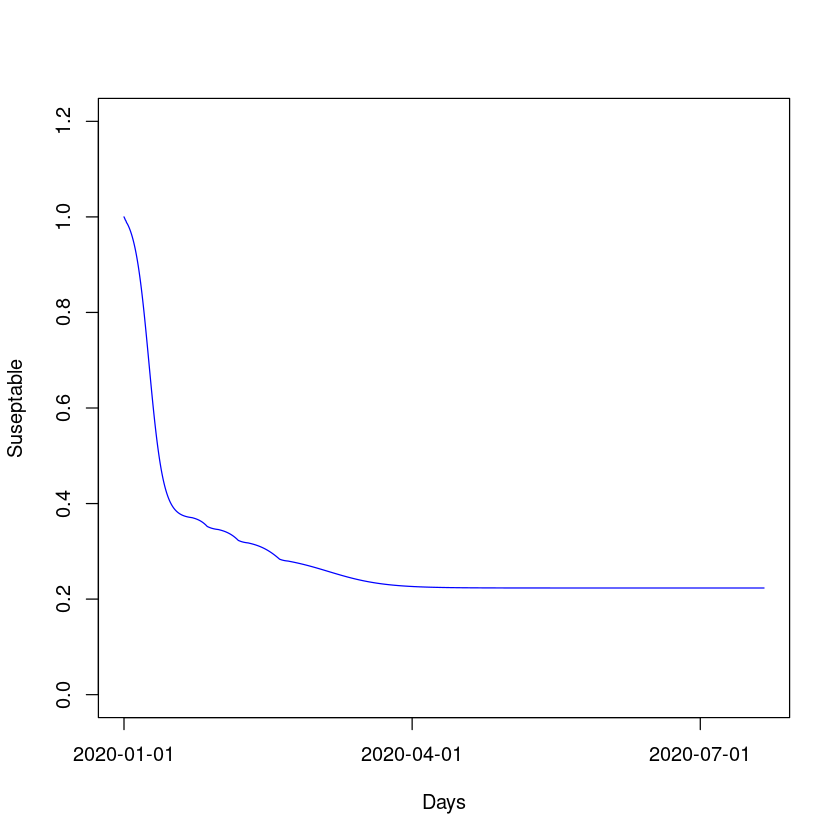

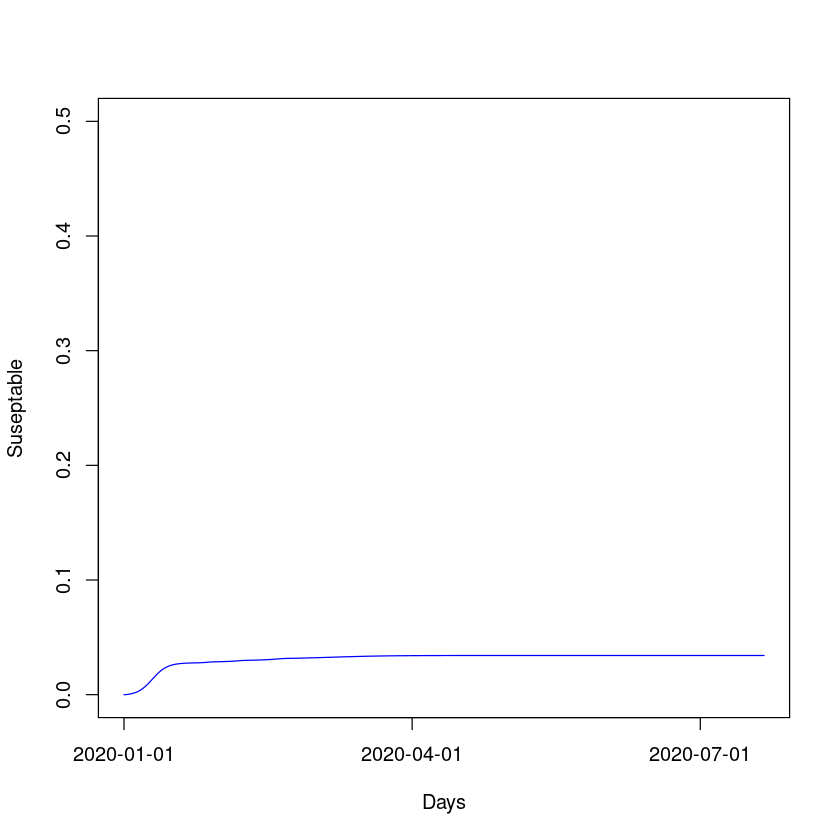

In [16]:
xd=seq(as.Date("2020-1-1"),length=100,by="3 months")
plot (out$state[,3]*10000,ylab="Infections per 10K",type="l",col="red",xlab="Days",xaxt="n", ylim=c(0,100))
int=seq(1,nrow(out$states),by=900)
axis(1,at=int,labels=xd[1:length(int)])

plot (out$state[,1],ylab="Suseptable",type="l",col="blue",xlab="Days",xaxt="n",ylim=c(0,1.2))
int=seq(1,nrow(out$states),by=900)
axis(1,at=int,labels=xd[1:length(int)])

plot (out$cases,ylab="Suseptable",type="l",col="blue",xlab="Days",xaxt="n",ylim=c(0,0.5))
int=seq(1,nrow(out$states),by=900)
axis(1,at=int,labels=xd[1:length(int)])

# End of SD distribution 

## multi-dist 

In [355]:
N_SAMP = 200
path='./'

f <- file.path(path, 'final_params.csv' )
params <- read.csv(f)

for (j in 1:dim(params)[1]){
    print(j)
    dir_j <- sprintf("r_gamma_sims_dist_sens_std/r_gamma_sims_dist_%.0f_nu46_long",j)
    dir.create(dir_j)
    
    mu_r = params$mu_r[j]
    std_r = sqrt(params$ss_r[j])
    mu_g = params$mu_g[j]
    std_g = sqrt(params$ss_g[j])
    r_dist <- rnorm(N_SAMP,mu_r,std_r)
    g_dist <-rnorm(N_SAMP,mu_g,std_g)
    joint_dist = rbind(r_dist,g_dist)

    startstate = c(1,0,0,0,0,0,0)
    startt = 70
    nu = 4.6


    for (i in seq(1,N_SAMP) ){
        dist_i = joint_dist[,i]

        r0 = dist_i[1]
        gamma = dist_i[2]


        if(r0>1 & gamma>1){
            print(r0)
            print(gamma)
            out = evolve (startstate=startstate, startt = startt, stopt = 365 + startt, policyparameters = list(distancingeffect = 0.0, hi = 37.5/1e4, low = 10/1e4), deltat=1,R0=r0,gamma=gamma,nu=nu)
            x = out$cases

            out2 = evolve (startstate=startstate, startt = startt, stopt = 10*365 + startt, policyparameters = list(distancingeffect = 0.6, hi = 37.5/1e4, low = 10/1e4), deltat=1,R0=r0,gamma=gamma,nu=nu)
            dist = out2$distancings

            endDist = tail(which(dist==1),n=1)-startt
            if(length(endDist)==0){
                endDist = 1      
            }

            name  <- sprintf("r_gamma_sims_dist_sens_std/r_gamma_sims_dist_%.0f_nu46_long/cases_r0_%.4f_endDist_%.1f_gamma_%.4f.csv",j,r0,endDist,gamma)
            write.csv(x,name)
        }



    }
}

[1] 1
  r_dist 
5.548196 
  g_dist 
10.37143 
  r_dist 
5.583581 
  g_dist 
10.58765 
 r_dist 
8.46327 
  g_dist 
14.37032 
  r_dist 
7.512661 
  g_dist 
11.61976 
  r_dist 
6.321276 
  g_dist 
24.45788 
  r_dist 
5.858713 
  g_dist 
4.578785 
  r_dist 
7.994832 
  g_dist 
13.75831 
  r_dist 
3.742146 
  g_dist 
26.72104 
  r_dist 
7.166953 
  g_dist 
17.41522 
  r_dist 
6.116548 
  g_dist 
13.69894 
 r_dist 
4.36126 
  g_dist 
20.88014 
  r_dist 
6.254816 
  g_dist 
33.65354 
  r_dist 
11.42595 
  g_dist 
20.64437 
  r_dist 
7.536433 
  g_dist 
7.888846 
 r_dist 
6.96522 
  g_dist 
4.327317 
  r_dist 
9.031158 
  g_dist 
10.20252 
  r_dist 
9.840838 
  g_dist 
5.410934 
  r_dist 
5.450054 
  g_dist 
3.114471 
 r_dist 
4.86915 
  g_dist 
13.03592 
  r_dist 
7.534015 
  g_dist 
16.89798 
  r_dist 
1.628285 
  g_dist 
17.92847 
  r_dist 
5.400403 
  g_dist 
6.864931 
  r_dist 
4.848076 
  g_dist 
4.314589 
  r_dist 
8.702774 
  g_dist 
21.53315 
  r_dist 
6.923239 
  g_dist 
9.784381 
  

## single dist 

In [364]:
N_SAMP = 1000
# 7.5   1.   17.  121. 
mu_r = 7.5
std_r = 1
mu_g = 17
std_g = 11



r_dist <- rnorm(N_SAMP,mu_r,std_r)
g_dist <-rnorm(N_SAMP,mu_g,std_g)
joint_dist = rbind(r_dist,g_dist)

startstate = c(1,0,0,0,0,0,0)
startt = 70
nu = 4.6


for (i in seq(1,N_SAMP) ){
    dist_i = joint_dist[,i]
    
    r0 = dist_i[1]
    gamma = dist_i[2]
    

    if(r0>1 & gamma>1){
        print(r0)
        print(gamma)
        out = evolve (startstate=startstate, startt = startt, stopt = 365 + startt, policyparameters = list(distancingeffect = 0.0, hi = 37.5/1e4, low = 10/1e4), deltat=1,R0=r0,gamma=gamma,nu=nu)
        x = out$cases

        out2 = evolve (startstate=startstate, startt = startt, stopt = 10*365 + startt, policyparameters = list(distancingeffect = 0.6, hi = 37.5/1e4, low = 10/1e4), deltat=1,R0=r0,gamma=gamma,nu=nu)
        dist = out2$distancings

        endDist = tail(which(dist==1),n=1)-startt
        if(length(endDist)==0){
            endDist = 1      
        }
        
        name  <- sprintf("r_gamma_sims_dist_nu46_long_nswd/cases_r0_%.4f_endDist_%.1f_gamma_%.4f.csv",r0,endDist,gamma)
        write.csv(x,name)
    }
    
    
    
}

  r_dist 
9.699613 
  g_dist 
13.37926 
  r_dist 
7.576728 
  g_dist 
13.67354 
  r_dist 
7.852514 
  g_dist 
30.14774 
  r_dist 
6.920606 
  g_dist 
13.31939 
  r_dist 
7.494628 
  g_dist 
25.14146 
  r_dist 
7.501511 
  g_dist 
26.73703 
  r_dist 
8.455909 
  g_dist 
22.88348 
  r_dist 
5.789907 
  g_dist 
17.30553 
  r_dist 
7.041295 
  g_dist 
20.15415 
 r_dist 
7.45609 
  g_dist 
9.296313 
  r_dist 
5.419971 
  g_dist 
27.62498 
  r_dist 
6.837948 
  g_dist 
18.89065 
  r_dist 
8.191744 
  g_dist 
33.25192 
  r_dist 
6.954718 
  g_dist 
15.48017 
  r_dist 
6.568382 
  g_dist 
44.84962 
  r_dist 
6.833343 
  g_dist 
12.54798 
  r_dist 
7.764649 
  g_dist 
20.24327 
 r_dist 
8.21401 
  g_dist 
31.73435 
 r_dist 
8.94264 
 g_dist 
18.0223 
  r_dist 
6.585195 
  g_dist 
4.429281 
  r_dist 
7.848902 
  g_dist 
5.139593 
  r_dist 
6.866493 
 g_dist 
19.7589 
  r_dist 
7.124125 
  g_dist 
12.29166 
  r_dist 
6.657241 
  g_dist 
11.11786 
  r_dist 
8.328521 
  g_dist 
6.248566 
  r_dist 


## social

In [ ]:
startstate = c(1,0,0,0,0,0,0)
startt = 70
nu = 4.6
r0 = 6.3
gamma = 16

for (i in seq(1,18) ){
    dist_i = joint_dist[,i]
    
    
    

    if(r0>1 & gamma>1){

        
        out = evolve (startstate=startstate, startt = startt, stopt = 365 + startt, policyparameters = list(distancingeffect = 0.0, hi = 37.5/1e4, low = 10/1e4), deltat=1,R0=r0,gamma=gamma,nu=nu)
        x = out$cases

        out2 = evolve (startstate=startstate, startt = startt, stopt = 10*365 + startt, policyparameters = list(distancingeffect = 0.05*i, hi = 37.5/1e4, low = 10/1e4), deltat=1,R0=r0,gamma=gamma,nu=nu)
        dist = out2$distancings

        endDist = tail(which(dist==1),n=1)-startt
        if(length(endDist)==0){
            endDist = 1      
        }
        
        name  <- sprintf("r_gamma_sims_dist_social_nu46_long_wswd/cases_r0_%.4f_endDist_%.1f_sd_%.0f_gamma_%.4f.csv",r0,endDist,i,gamma)
        write.csv(x,name)
    }
    
    
    
}